# 3D Quantum game of life

This work is heavly inspired by
Semi quantum simulation based on: https://arxiv.org/pdf/1902.07835.pdf.
and through QC hack's IBM  Grover algorithm Workshop
  


## Just importing important stuff

In [13]:
import numpy as np
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile, Aer, IBMQ, execute
from qiskit.quantum_info import Operator, Statevector
from qiskit.providers.ibmq import least_busy
from qiskit.tools.jupyter import *
from qiskit.visualization import *

provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2021-04-11 13:04:12,223: Credentials are already in use. The existing account in the session will be replaced.


this is inspired by grover algorithm and creation of an oracle function

I created oracle function from the tutorials porvided but didn't have a use case just yet  

In [2]:
def phase_oracle(n, indices_to_make, name='Magic'):
    qc = QuantumCircuit(n,name=name)
    matx =np.identity(2**n)
    for index in indices_to_make:
        matx[index,index]=-1
    qc.unitary(Operator(matx),range(n))
    qc.draw()
    return qc


def diffuser(n):
    qc = QuantumCircuit(n,name='Diff')
    qc.h(range(n))
    qc.append(phase_oracle(n,[0]),range(n))
    qc.h(range(n))
    qc.draw()
    return qc

# big ball of wibbly-wobbly, timey-wimey
def something(n,marked):
    qc = QuantumCircuit(n)
    print(f'{n} qubits, basis state {marked} marked')
    qc.h(range(n))
    qc.append(phase_oracle(n,marked),range(n))
    qc.append(diffuser(n),range(n))
    return qc

In [3]:
n=5
x=np.random.randint(20)
marked=[x]
qc = QuantumCircuit(n,n)
qc.append(something(n,marked),range(n))
    
qc.measure(range(n),range(n))  
qc.draw()

5 qubits, basis state [16] marked


┌───────────┐┌─┐            
q_0: ┤0          ├┤M├────────────
     │           │└╥┘┌─┐         
q_1: ┤1          ├─╫─┤M├─────────
     │           │ ║ └╥┘┌─┐      
q_2: ┤2 circuit8 ├─╫──╫─┤M├──────
     │           │ ║  ║ └╥┘┌─┐   
q_3: ┤3          ├─╫──╫──╫─┤M├───
     │           │ ║  ║  ║ └╥┘┌─┐
q_4: ┤4          ├─╫──╫──╫──╫─┤M├
     └───────────┘ ║  ║  ║  ║ └╥┘
c: 5/══════════════╩══╩══╩══╩══╩═
                   0  1  2  3  4


I used this as a reference where the center is the visiting point the adjacent points provide liveness index


 
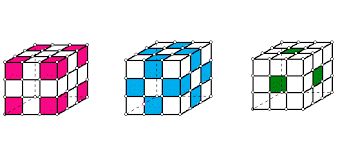

* the red points (corner points) have a 0.125*value added to liveness index of center point 
* the blue points (edge points) have a 0.25*value added to liveness index of center point
* the green point (face points) have a 0.5*value added   to liveness index of center point

the ``` gol ``` function is the main function which contains the major Quantum circuit  which first initializes a  liveness index of the said point and use this to set the index of QRegister 

In [35]:
def live(nh):
    v=nh
    a=0
    for i in [0,2]:
        a+=(v[1][1][i]+v[i][1][1]+v[1][i][1])/2
    for i in [0,2]:
        a+=(v[0][i][0]+v[0][i][2]+v[2][i][0]+v[2][i][2])/8
    a+=(v[1][0][0]+v[1][2][2]+v[1][2][0]+v[1][0][2]+v[0][0][1]+v[0][1][0]+v[0][1][2]+v[0][2][1]+v[2][0][1]+v[2][1][0]+v[2][1][2]+v[2][2][1])/4
    return a

def gol(nh):
    a=live(nh)
    
    value=nh[1][1][1]
    alive = np.array([1.0,0.0])
    dead = np.array([0.0,1.0])
    B = np.array([[0,0],[1,1]])
    D = np.array([[1,1],[0,0]])
    S = np.array([[1,0],[0,1]])
    
    if a <= 1:
        value =  dead
    elif (a > 1 and a <= 3):
        value = ((np.sqrt(2)+1)*2-(np.sqrt(2)+1)*a)*dead+(a-1)*value#(((np.sqrt(2)+1)*(2-a))**2+(a-1)**2)
    elif (a > 3 and a <= 4):
        value = (((np.sqrt(2)+1)*3)-(np.sqrt(2)+1)*a)*value+(a-2)*alive#(((np.sqrt(2)+1)*(3-a))**2+(a-2)**2)
    elif (a > 4 and a < 5):
        value = ((np.sqrt(2)+1)*4-(np.sqrt(2)+1)*a)*alive+(a-3)*dead#(((np.sqrt(2)+1)*(4-a))**2+(a-3)**2)
    elif a >= 5:
        value = dead
    
    value = value/np.linalg.norm(value)
    a=a/8
    a = a/np.linalg.norm(a)
    qr = QuantumRegister(5)
    cr = ClassicalRegister(5)
    qc = QuantumCircuit(qr, cr,name='Morpheous')
    qc.initialize([a,0],[qr[0]])
    qc.initialize(value,[qr[1]])
    qc.initialize(value,[qr[2]])
    qc.cx(qr[0],qr[2])
    qc.cx(qr[1],qr[3])
    qc.cx(qr[2],qr[4])
    qc.cx(qr[4],qr[1])
    
    qc.barrier()
    qc.append(something(5,[int(a)]),range(5)) #had some issues h 
    qc.append(diffuser(5),range(5))
    qc.measure(range(n),range(n)) 
    print(qc.draw())
    back = Aer.get_backend('qasm_simulator')
    result = execute(qc,back,shots=2048).result()
    counts = result.get_counts(qc)
    print(counts)
    
    
    
    #for i in data:
        
    
    return counts


In [36]:
t=np.random.rand(3,3,3)
t[1][2][1]=1
qc=gol(t)

5 qubits, basis state [1] marked
              ┌─────────────────┐                            ░ ┌─────────────┐»
q58_0: ───────┤ initialize(1,0) ├─────────■──────────────────░─┤0            ├»
       ┌──────┴─────────────────┴──────┐  │            ┌───┐ ░ │             │»
q58_1: ┤ initialize(-0.018749,0.99982) ├──┼────■───────┤ X ├─░─┤1            ├»
       ├───────────────────────────────┤┌─┴─┐  │       └─┬─┘ ░ │             │»
q58_2: ┤ initialize(-0.018749,0.99982) ├┤ X ├──┼────■────┼───░─┤2 circuit219 ├»
       └───────────────────────────────┘└───┘┌─┴─┐  │    │   ░ │             │»
q58_3: ──────────────────────────────────────┤ X ├──┼────┼───░─┤3            ├»
                                             └───┘┌─┴─┐  │   ░ │             │»
q58_4: ───────────────────────────────────────────┤ X ├──■───░─┤4            ├»
                                                  └───┘      ░ └─────────────┘»
 c7: 5/═══════════════════════════════════════════════════════════════════════»
       

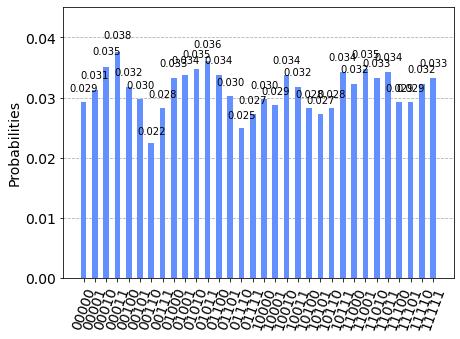

In [38]:
plot_histogram(qc)